# Text Enrichment

The objective of text enrichment is to utilize computational techniques of automatic annotations and extract additional linguistic information from the text.

## Parts-of-Speech (POS) Tagging

- Every POS tagger needs to first operationlize a tagset, i.e., a complete list of possible tags for the entire corpus.
- A common tagset for English is [Penn-treebank tagset](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html).


### NLTK

- NLTK default POS tagger

In [1]:
import nltk
text = "This is a sentence."
text_word = nltk.word_tokenize(text)
text_pos = nltk.pos_tag(text_word)
print(text_pos)

[('This', 'DT'), ('is', 'VBZ'), ('a', 'DT'), ('sentence', 'NN'), ('.', '.')]


- Using NLTK to Train Taggers

In [2]:
from nltk.corpus import treebank
print(len(treebank.tagged_sents())) # total number of sents

# train-test for training and testing taggers
test_sents = treebank.tagged_sents()[3000:]
train_sents = treebank.tagged_sents()[:3000]

3914


In [3]:
test_sents[1]

[('In', 'IN'),
 ('early', 'RB'),
 ('trading', 'NN'),
 ('in', 'IN'),
 ('Tokyo', 'NNP'),
 ('Thursday', 'NNP'),
 (',', ','),
 ('the', 'DT'),
 ('Nikkei', 'NNP'),
 ('index', 'NN'),
 ('fell', 'VBD'),
 ('63.79', 'CD'),
 ('points', 'NNS'),
 ('to', 'TO'),
 ('35500.64', 'CD'),
 ('.', '.')]

- NgramTagger

![](../images/nltk-fig-5-1-tag-context.png) <small>(From NLTK Book Ch 5. Figure 5-1)</small>


In [4]:
from nltk.tag import UnigramTagger, BigramTagger, TrigramTagger

unigram_tagger = UnigramTagger(train_sents)
bigram_tagger = BigramTagger(train_sents)
trigram_tagger = TrigramTagger(train_sents)


In [5]:
unigram_tagger.evaluate(test_sents)

0.8571551910209367

In [6]:
bigram_tagger.evaluate(test_sents)

0.11318799913662854

In [7]:
trigram_tagger.evaluate(test_sents)

0.06902654867256637

- NLTK Taggers (`nltk.tag`):
    - `DefaultTagger`
    - `UnigramTagger`, `BigramTagger`, `TrigramTagger`
    - `RegexpTagger`
    - `AffixTagger`
    - `ClassifierBasedPOSTagger`

- Backoff Tagging
    - The idea of **backoff** is that for longer sequences, we are more likely to encounter *unseen* n-grams in the test data.
    - To avoid the zero probability issue due to the unseen **n**-grams, we can backoff the probability estimates using the lower-order (**n-1**)-grams.

In [8]:
unigram_tagger = UnigramTagger(train_sents)
bigram_tagger = BigramTagger(train_sents,backoff=unigram_tagger)
trigram_tagger = TrigramTagger(train_sents, backoff=bigram_tagger)

In [9]:
trigram_tagger.evaluate(test_sents)

0.8647096913447011

:::{tip}
Sometimes it may take a while to train a tagger. We can pickle a trained tagger for later usage.

```
import pickle
f = open('trigram-backoff-tagger.pickle', 'wb')
f.close()
f = open('trigram-backoff-tagger.pickle', 'rb')
tagger = pickle.load(f)
```
:::

- Classifier-based Tagger

In [10]:
from nltk.tag.sequential import ClassifierBasedPOSTagger
cbtagger = ClassifierBasedPOSTagger(train=train_sents)
cbtagger.evaluate(test_sents)

0.9309734513274336

```{note}
By default, the `ClassifierBasedPOSTagger` uses a `NaiveBayesClassifier` for training.
```

To try other classifers, e.g., Maximum Entropy Classifier:

In [11]:
import numpy
# warning is not logged here. Perfect for clean unit test output
with numpy.errstate(divide='ignore'):
    numpy.float64(1.0) / 0.0

In [12]:
%%time

from nltk.classify import MaxentClassifier
metagger = ClassifierBasedPOSTagger(train=train_sents,
                                   classifier_builder=MaxentClassifier.train)
metagger.evaluate(test_sents)

  ==> Training (100 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -3.82864        0.008
             2          -0.76859        0.957


/Users/alvinchen/opt/anaconda3/envs/python-notes/lib/python3.7/site-packages/nltk/classify/maxent.py:1386: RuntimeWarning: overflow encountered in power
  exp_nf_delta = 2 ** nf_delta
/Users/alvinchen/opt/anaconda3/envs/python-notes/lib/python3.7/site-packages/nltk/classify/maxent.py:1388: RuntimeWarning: invalid value encountered in multiply
  sum1 = numpy.sum(exp_nf_delta * A, axis=0)
/Users/alvinchen/opt/anaconda3/envs/python-notes/lib/python3.7/site-packages/nltk/classify/maxent.py:1389: RuntimeWarning: invalid value encountered in multiply
  sum2 = numpy.sum(nf_exp_nf_delta * A, axis=0)


         Final               nan        0.984


0.9258363911072739

- Classifier-based with Cut-off Probability

In [13]:
from nltk.tag import DefaultTagger

default = DefaultTagger('NN')
cbtagger2 = ClassifierBasedPOSTagger(train=train_sents,
                                    backoff=default,
                                    cutoff_prob=0.3)

cbtagger2.evaluate(test_sents)

0.9311029570472696

### spacy

- Another useful module for English POS tagging is to use `spacy`. We will come back to this module when we talk about parsing.

## Chunking

- **Chunk** extraction is the processing of extracting short phrases from a part-of-speech tagged sentence.
- This is different from parsing in that we are only interested in standalone chunks or phrases, instead of the full parsed syntactic tree.

- In NLTK, A `ChunkRule` class specifies what to *include* in a chunk, while a `ChinkRule` class specifies what to *exclude* from a chunk.
- **Chunking** creates chunks and **chinking** breaks up those chunks.
- Both rules utilize **regular expressions**.

- For example, we can extract NP chunks.

In [14]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150 # default for me was 75
plt.rcParams['figure.figsize'] = (20,20)
%matplotlib inline

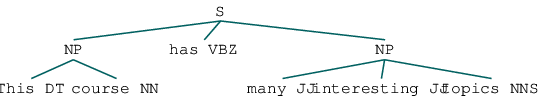

In [15]:
from nltk.chunk import RegexpParser
np_chunker = RegexpParser(r'''
NP:
{<DT><NN.*><.*>*<NN.*>} # chunk
}<VB.*>{ # chink
''')

s = "This course has many interesting topics"
np_chunker.parse(nltk.pos_tag(nltk.word_tokenize(s)))

We can define a function to extract chunks from the tree.

In [16]:
def sub_leaves(tree, label):
    return [t.leaves() for t in 
            tree.subtrees(lambda s:s.label()==label)]

In [17]:
s_chunk_tree = np_chunker.parse(
    nltk.pos_tag(
        nltk.word_tokenize(s)))

sub_leaves(s_chunk_tree, "NP")

[[('This', 'DT'), ('course', 'NN')],
 [('many', 'JJ'), ('interesting', 'JJ'), ('topics', 'NNS')]]

- Named Entity Chunker (NLTK)

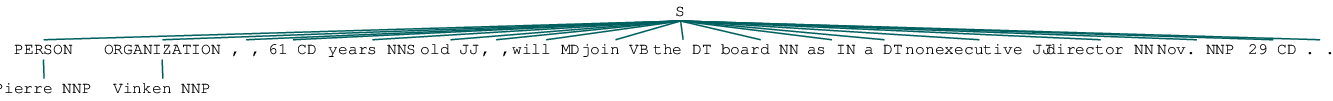

In [18]:
from nltk.chunk import ne_chunk

ne_chunks=ne_chunk(treebank.tagged_sents()[0])
ne_chunks

In [19]:
sub_leaves(ne_chunks, "PERSON")

[[('Pierre', 'NNP')]]

In [20]:
sub_leaves(ne_chunks, "ORGANIZATION")

[[('Vinken', 'NNP')]]

## Parsing

For Parsing, we will use `spacy`, a powerful package for natural language processing.

In [21]:
import spacy
from spacy import displacy
# load language model
nlp_en = spacy.load('en_core_web_sm') 
# parse text 
doc = nlp_en('This is a sentence')

In [22]:
for token in doc:
    print((token.text, 
            token.lemma_, 
            token.pos_, 
            token.tag_,
            token.dep_,
            token.shape_,
            token.is_alpha,
            token.is_stop,
            ))

('This', 'this', 'DET', 'DT', 'nsubj', 'Xxxx', True, True)
('is', 'be', 'AUX', 'VBZ', 'ROOT', 'xx', True, True)
('a', 'a', 'DET', 'DT', 'det', 'x', True, True)
('sentence', 'sentence', 'NOUN', 'NN', 'attr', 'xxxx', True, False)


In [23]:
## Check meaning of a POS tag
spacy.explain('VBZ')

'verb, 3rd person singular present'

In [24]:
# Visualize
displacy.render(doc, style="dep")

In [25]:
options = {"compact": True, "bg": "#09a3d5",
           "color": "white", "font": "Source Sans Pro"}
displacy.render(doc, style="dep", options=options)

- To get the dependency relations, we first need to extract NP chunks, on which dependency relations are annotated.
- Please refer to [spacy documentation](https://spacy.io/usage/linguistic-features#dependency-parse) for more detail on dependency parsing.

In [26]:
doc2 = nlp_en(' '.join(treebank.sents()[0]))

for c in doc2.noun_chunks:
    print((c.text, 
           c.root.text, 
           c.root.dep_, 
           c.root.head.text))

('Pierre Vinken', 'Vinken', 'nsubj', 'join')
('the board', 'board', 'dobj', 'join')
('a nonexecutive director', 'director', 'pobj', 'as')


Each NP chunk includes several important pieces of information:
- **Text**: The original noun chunk text.
- **Root text**: The original text of the word connecting the noun chunk to the rest of the parse.
- **Root dep**: Dependency relation connecting the root to its head.
- **Root head text**: The text of the root token’s head.

In [27]:
displacy.render(doc2, style="dep")

- Named Entity Extraction

In [28]:
for ent in doc2.ents:
    print((ent.text,
           ent.start_char,
           ent.end_char,
           ent.label_))

('Pierre Vinken', 0, 13, 'PERSON')
('61 years old', 16, 28, 'DATE')
('Nov. 29', 78, 85, 'DATE')


- Please check the documentation of [Universal Dependency Types](https://universaldependencies.org/docs/u/dep/index.html) proposed by [Marneffe et al.](https://nlp.stanford.edu/pubs/USD_LREC14_paper_camera_ready.pdf)

## References

- [NLTK Ch.5 Categorizing and Tagging Words](http://www.nltk.org/book/ch05.html)